In [236]:
# The following libraries will let you use opencv
import cv2 #opencv itself
import numpy as np # matrix manipulations
import pandas as pd # dataframes
import os
#the following are to do with this interactive notebook code
%matplotlib inline 
from matplotlib import pyplot as plt # this lets you draw inline pictures in the notebooks

In [237]:
def face_detect(photo, scaleFactor=1.2, minNeighbors=5, facecolor =(255,0,0), eyecolor =(0,255,0), smilecolor =(0,0,255), thickness=2, smilescale = 2, eyescale = 4):
    person_grey = cv2.cvtColor(photo, cv2.COLOR_BGR2GRAY)
    photo = cv2.cvtColor(photo, cv2.COLOR_BGR2RGB)
    #person_grey = cv2.GaussianBlur(person_grey, (5, 5),0)
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    smile_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_smile.xml')
    eyes_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_eye.xml')
    faces = face_cascade.detectMultiScale(person_grey, scaleFactor=scaleFactor, minNeighbors=minNeighbors)
    max_width = 0
    max_height = 0
    for (x, y, w, h) in faces:
        cv2.rectangle(photo, (x, y), (x+w, y+h), facecolor, thickness)
        max_width = w if w > max_width else max_width
        max_height = h if h > max_height else max_height

    smile_max_width = int(max_width / smilescale)
    smile_max_height = int(max_height / smilescale)
    smile = smile_cascade.detectMultiScale(person_grey, scaleFactor=scaleFactor, minNeighbors=minNeighbors, maxSize=(smile_max_width,smile_max_height))
    for (x, y, w, h) in smile:
        cv2.rectangle(photo, (x, y), (x+w, y+h), smilecolor, thickness)

    eyes_max_width = int(max_width / eyescale)
    eyes_max_height = int(max_height / eyescale)
    eyes = eyes_cascade.detectMultiScale(person_grey, scaleFactor=scaleFactor, minNeighbors=minNeighbors, maxSize=(eyes_max_width,eyes_max_height))
    for (x, y, w, h) in eyes:
        cv2.rectangle(photo, (x, y), (x+w, y+h), eyecolor, thickness)

    cv2.putText(photo,'Face', (0,(int(0.05*photo.shape[1]))), cv2.FONT_HERSHEY_PLAIN, 1, facecolor, 1)
    cv2.putText(photo,'Smile', (0,(int(0.1*photo.shape[1]))), cv2.FONT_HERSHEY_PLAIN, 1, smilecolor, 1)
    cv2.putText(photo,'Eyes', (0,(int(0.15*photo.shape[1]))), cv2.FONT_HERSHEY_PLAIN, 1, eyecolor, 1)

    plt.imshow(photo)

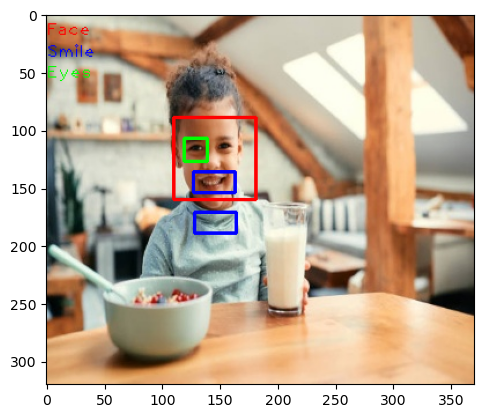

In [238]:
face_detect(cv2.imread('data/control/3.jpg'))


In [243]:
def proportions(photo, scaleFactor=1.1, minNeighbors=5):
    person_grey = cv2.cvtColor(photo, cv2.COLOR_BGR2GRAY)
    photo = cv2.cvtColor(photo, cv2.COLOR_BGR2RGB)
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    smile_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_smile.xml')
    eye_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_eye.xml')
    faces = face_cascade.detectMultiScale(person_grey, scaleFactor=scaleFactor, minNeighbors=minNeighbors)
    n = 0
    data = pd.DataFrame(columns=['Face', 'Face_x', 'Face_y', 'Face_w', 'Face_h', 'Smile_x', 'Smile_y', 'Smile_w', 'Smile_h', 'Eye1_x', 'Eye1_y', 'Eye1_w', 'Eye1_h', 'Eye2_x', 'Eye2_y', 'Eye2_w', 'Eye2_h'])
    for (x, y, w, h) in faces:
        cv2.rectangle(photo, (x, y), (x+w, y+h), [255,0,0], 1)
        n += 1
        data.loc[n, 'Face'] = n
        smile = smile_cascade.detectMultiScale(person_grey[y:(y+h), x:(x+w)], scaleFactor=scaleFactor, minNeighbors=minNeighbors)
        data.loc[n, ['Face_x', 'Face_y', 'Face_w', 'Face_h']] = [x, y, w, h]
        for (xs, ys, ws, hs) in smile:
            data.loc[n, ['Smile_x', 'Smile_y', 'Smile_w', 'Smile_h']] = [x+xs, y+ys, ws, hs]
        eye = eye_cascade.detectMultiScale(person_grey[y:(y+h), x:(x+w)], scaleFactor=scaleFactor, minNeighbors=minNeighbors)
        for (xe, ye, we, he) in eye:
            if pd.isna(data.loc[n, 'Eye1_x']):
                data.loc[n, ['Eye1_x', 'Eye1_y', 'Eye1_w', 'Eye1_h']] = [x+xe, y+ye, we, he]
            elif pd.isna(data.loc[n, 'Eye2_x']):
                data.loc[n, ['Eye2_x', 'Eye2_y', 'Eye2_w', 'Eye2_h']] = [x+xe, y+ye, we, he]
    return(data)

In [244]:
facial_data = proportions(cv2.imread('Images/Day 2_Programming Lab_Person.jpg'), 1.1, 5)

facial_data

,Face,Face_x,Face_y,Face_w,Face_h,Smile_x,Smile_y,Smile_w,Smile_h,Eye1_x,Eye1_y,Eye1_w,Eye1_h,Eye2_x,Eye2_y,Eye2_w,Eye2_h
1,1,181,47,137,137,209,134,71,36,206,78,38,38,254,86,37,37


In [263]:
def proportions_processing(data):
    required_columns = ['Smile_w_prop', 'Eye1_w_prop', 'Eye2_w_prop', 'Smile_h_prop', 'Eye1_h_prop', 'Eye2_h_prop', 'forehead_prop', 'nose_prop', 'chin_prop']

    if type(data) == pd.DataFrame:
        missing_columns = [col for col in required_columns if col not in data.columns]
        for col in missing_columns:
            data[col] = np.nan

        data[['Smile_w_prop', 'Eye1_w_prop', 'Eye2_w_prop']] = data[['Smile_w', 'Eye1_w', 'Eye2_w']].div(data['Face_w'], axis=0)
        data[['Smile_h_prop', 'Eye1_h_prop', 'Eye2_h_prop']] = data[['Smile_h', 'Eye1_h', 'Eye2_h']].div(data['Face_h'], axis=0)
        data['forehead_prop'] = ((((data['Face_y']+data['Face_h'])-np.mean([(data['Eye1_y']+data['Eye1_h']),(data['Eye2_y']+data['Eye2_h'])]))/data['Face_h']).iloc[0])
        data['nose_prop'] = ((((np.mean([(data['Eye1_y']+0.5*data['Eye1_h']),(data['Eye2_y']+0.5*data['Eye2_h'])]))-(data['Smile_y']+data['Smile_h']))/data['Face_h']).iloc[0])
        data['chin_prop'] = (((data['Smile_y']-data['Face_y'])/data['Face_h']).iloc[0])
    else:
        missing_columns = [col for col in required_columns if col not in data.index]
        for col in missing_columns:
            data[col] = np.nan

        data[['Smile_w_prop', 'Eye1_w_prop', 'Eye2_w_prop']] = data[['Smile_w', 'Eye1_w', 'Eye2_w']].div(data['Face_w'], axis=0)
        data[['Smile_h_prop', 'Eye1_h_prop', 'Eye2_h_prop']] = data[['Smile_h', 'Eye1_h', 'Eye2_h']].div(data['Face_h'], axis=0)
        data['forehead_prop'] = ((((data['Face_y']+data['Face_h'])-np.mean([(data['Eye1_y']+data['Eye1_h']),(data['Eye2_y']+data['Eye2_h'])]))/data['Face_h']))
        data['nose_prop'] = ((((np.mean([(data['Eye1_y']+0.5*data['Eye1_h']),(data['Eye2_y']+0.5*data['Eye2_h'])]))-(data['Smile_y']+data['Smile_h']))/data['Face_h']))
        data['chin_prop'] = (((data['Smile_y']-data['Face_y'])/data['Face_h']))
    return(data)

In [ ]:
data = facial_data.copy()

proportions_processing(data)

In [286]:
def proportions_overlay(photo, data, facecolor =(255,0,0), eyecolor =(0,255,0), smilecolor =(0,0,255), thickness=2):
    photo = cv2.cvtColor(photo, cv2.COLOR_BGR2RGB)

    try:
        data = dict(data.iloc[0])
    except:
        print("No face detected")
        return

    if any(pd.isna([data['Face_x'], data['Face_y'], data['Face_w'], data['Face_h']])):
        print("No face detected")
    else:
        cv2.rectangle(photo, (data['Face_x'], data['Face_y']), (data['Face_x']+data['Face_w'], data['Face_y']+data['Face_h']), facecolor, thickness)
        cv2.putText(photo,'Face', (0,15), cv2.FONT_HERSHEY_PLAIN, 1, facecolor, 1)
        
    if any(pd.isna([data['Smile_x'], data['Smile_y'], data['Smile_w'], data['Smile_h']])):
        print("No smile detected")
    else:
        pt1 = (int(data['Smile_x']), int(data['Smile_y']))
        pt2 = (int(data['Smile_x'] + data['Smile_w']), int(data['Smile_y'] + data['Smile_h']))
        cv2.rectangle(photo, pt1, pt2, smilecolor, thickness)
        #cv2.rectangle(photo, (data['Smile_x'], data['Smile_y']), ((data['Smile_x']+data['Smile_w']), (data['Smile_y']+data['Smile_h'])), smilecolor, thickness)
        cv2.putText(photo,'Smile', (0,30), cv2.FONT_HERSHEY_PLAIN, 1, smilecolor, 1)
        cv2.putText(photo,str(data['Smile_w_prop']), ((data['Smile_x']-35),int(data['Smile_y']+(data['Smile_y']+data['Smile_h'])/2)), cv2.FONT_HERSHEY_PLAIN, 1, smilecolor, 1)
        cv2.putText(photo,str(data['Smile_h_prop']), (int(data['Smile_x']+(data['Smile_w'])/2),(data['Smile_y']-10)), cv2.FONT_HERSHEY_PLAIN, 1, smilecolor, 1)
    
    if any(pd.isna([data['Eye1_x'], data['Eye1_y'], data['Eye1_w'], data['Eye1_h']])):
        print("No eye detected")
    else:
        
        pt1 = (int(data['Eye1_x']), int(data['Eye1_y']))
        pt2 = (int(data['Eye1_x'] + data['Eye1_w']), int(data['Eye1_y'] + data['Eye1_h']))
        cv2.rectangle(photo, pt1, pt2, eyecolor, thickness)

        #cv2.rectangle(photo, (data['Eye1_x'], data['Eye1_y']), (data['Eye1_x']+data['Eye1_w'], data['Eye1_y']+data['Eye1_h']), eyecolor, thickness)
        cv2.putText(photo,'Eyes', (0,50), cv2.FONT_HERSHEY_PLAIN, 1, eyecolor, 1)
        cv2.putText(photo,str(data['Eye1_w_prop']), ((data['Eye1_x']-35),int(data['Eye1_y']+(data['Eye1_y']+data['Eye1_h'])/2)), cv2.FONT_HERSHEY_PLAIN, 1, eyecolor, 1)
        cv2.putText(photo,str(data['Eye1_h_prop']), (int(data['Eye1_x']+(data['Eye1_w'])/2),(data['Eye1_y']-10)), cv2.FONT_HERSHEY_PLAIN, 1, eyecolor, 1)
        
    if any(pd.isna([data['Eye2_x'], data['Eye2_y'], data['Eye2_w'], data['Eye2_h']])):
        print("Second eye not detected")
    else:
        cv2.rectangle(photo, (data['Eye2_x'], data['Eye2_y']), (data['Eye2_x']+data['Eye2_w'], data['Eye2_y']+data['Eye2_h']), eyecolor, thickness)
        cv2.putText(photo,str(data['Eye2_w_prop']), ((data['Eye2_x']-35),int(data['Eye2_y']+(data['Eye2_y']+data['Eye2_h'])/2)), cv2.FONT_HERSHEY_PLAIN, 1, eyecolor, 1)
        cv2.putText(photo,str(data['Eye2_h_prop']), (int(data['Eye2_x']+(data['Eye2_w'])/2),(data['Eye2_y']-10)), cv2.FONT_HERSHEY_PLAIN, 1, eyecolor, 1)

    plt.imshow(photo)

In [ ]:
control_data = pd.DataFrame()
for files in os.listdir('.\data\control'):
    if files.endswith('.jpg') or files.endswith('.png') or files.endswith('.jpeg'):
        print(f"Processing {files}")
        img = cv2.imread(os.path.join('.\data\control', files))
        data = proportions(img, 1.1, 5)
        data['Image'] = files
        control_data = pd.concat([control_data, data], ignore_index=True)

Processing 0.jpg
Processing 1.jpg
Processing 10.jpg
Processing 100.jpg
Processing 101.jpg
Processing 102.jpg
Processing 103.jpg
Processing 104.jpg
Processing 105.jpg
Processing 106.jpg
Processing 107.jpg
Processing 108.jpg
Processing 109.jpg
Processing 11.jpg
Processing 110.jpg
Processing 111.jpg
Processing 112.jpg
Processing 113.jpg
Processing 114.jpg
Processing 115.jpg
Processing 116.jpg
Processing 117.jpg
Processing 118.jpg
Processing 119.jpg
Processing 12.jpg
Processing 120.jpg
Processing 121.jpg
Processing 122.jpg
Processing 123.jpg
Processing 124.jpg
Processing 125.jpg
Processing 126.jpg
Processing 127.jpg
Processing 128.jpg
Processing 129.jpg
Processing 13.jpg
Processing 130.jpg
Processing 131.jpg
Processing 132.jpg
Processing 133.jpg
Processing 134.jpg
Processing 135.jpg
Processing 136.jpg
Processing 137.jpg
Processing 138.jpg
Processing 139.jpg
Processing 14.jpg
Processing 140.jpg
Processing 141.jpg
Processing 142.jpg
Processing 143.jpg
Processing 144.jpg
Processing 145.jpg
Pr

In [ ]:
noncontrol_data = pd.DataFrame()
for files in os.listdir('.\data\downSyndrome'):
    if files.endswith('.jpg') or files.endswith('.png') or files.endswith('.jpeg'):
        print(f"Processing {files}")
        img = cv2.imread(os.path.join('.\data\downSyndrome', files))
        data = proportions(img, 1.1, 5)
        data['Image'] = files
        noncontrol_data = pd.concat([noncontrol_data, data], ignore_index=True)

Processing down_1.jpg
Processing down_10.jpg
Processing down_100.jpg
Processing down_1000.jpg
Processing down_1001.jpg
Processing down_1002.jpg
Processing down_1003.jpg
Processing down_1004.jpg
Processing down_1005.jpg
Processing down_1006.jpg
Processing down_1007.jpg
Processing down_1008.jpg
Processing down_1009.jpg
Processing down_101.jpg
Processing down_1010.jpg
Processing down_1011.jpg
Processing down_1012.jpg
Processing down_1013.jpg
Processing down_1014.jpg
Processing down_1015.jpg
Processing down_1016.jpg
Processing down_1017.jpg
Processing down_1018.jpg
Processing down_1019.jpg
Processing down_102.jpg
Processing down_1020.jpg
Processing down_1021.jpg
Processing down_1022.jpg
Processing down_1023.jpg
Processing down_1024.jpg
Processing down_1025.jpg
Processing down_1026.jpg
Processing down_1027.jpg
Processing down_1028.jpg
Processing down_1029.jpg
Processing down_103.jpg
Processing down_1030.jpg
Processing down_1031.jpg
Processing down_1032.jpg
Processing down_1033.jpg
Processin

In [ ]:
control_data['Classification'] = 'Control'
noncontrol_data['Classification'] = 'DownSyndrome'

all_data = pd.concat([control_data, noncontrol_data], ignore_index=True)

writer = pd.ExcelWriter('all_data_raw.xlsx')
all_data.to_excel(writer, sheet_name='Sheet1', index=False)

all_data.isnull().sum()

Face                0
Face_x              0
Face_y              0
Face_w              0
Face_h              0
Smile_x           229
Smile_y           229
Smile_w           229
Smile_h           229
Eye1_x            179
Eye1_y            179
Eye1_w            179
Eye1_h            179
Eye2_x            334
Eye2_y            334
Eye2_w            334
Eye2_h            334
Image               0
Classification      0
dtype: int64

In [265]:
data_processed = all_data.apply(proportions_processing, axis=1)
data_processed = data_processed.dropna()

data_processed

,Face,Face_x,Face_y,Face_w,Face_h,Smile_x,Smile_y,Smile_w,Smile_h,Eye1_x,...,Classification,Smile_w_prop,Eye1_w_prop,Eye2_w_prop,Smile_h_prop,Eye1_h_prop,Eye2_h_prop,forehead_prop,nose_prop,chin_prop
6,1,119,103,130,130,137.0,182.0,86.0,43.0,157.0,...,Control,0.661538,0.261538,0.223077,0.330769,0.261538,0.223077,0.288462,-0.348077,0.607692
9,1,145,54,85,85,160.0,109.0,44.0,22.0,157.0,...,Control,0.517647,0.282353,0.270588,0.258824,0.282353,0.270588,0.482353,-0.526471,0.647059
15,1,97,82,87,87,121.0,143.0,46.0,23.0,114.0,...,Control,0.528736,0.241379,0.333333,0.264368,0.241379,0.333333,0.471264,-0.580460,0.701149
16,1,184,110,82,82,199.0,170.0,37.0,19.0,226.0,...,Control,0.451220,0.256098,0.304878,0.231707,0.256098,0.304878,0.426829,-0.530488,0.731707
17,1,170,130,100,100,198.0,197.0,45.0,22.0,218.0,...,Control,0.450000,0.280000,0.250000,0.220000,0.280000,0.250000,0.515000,-0.537500,0.670000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1303,1,99,94,390,390,289.0,377.0,100.0,50.0,182.0,...,DownSyndrome,0.256410,0.161538,0.058974,0.128205,0.161538,0.058974,0.439744,-0.348718,0.725641
1304,1,35,66,107,107,73.0,146.0,45.0,23.0,92.0,...,DownSyndrome,0.420561,0.233645,0.214953,0.214953,0.233645,0.214953,0.490654,-0.565421,0.747664
1305,1,79,123,156,156,103.0,154.0,111.0,55.0,177.0,...,DownSyndrome,0.711538,0.179487,0.307692,0.352564,0.179487,0.307692,0.500000,-0.173077,0.198718
1307,1,45,60,124,124,75.0,138.0,67.0,34.0,114.0,...,DownSyndrome,0.540323,0.241935,0.258065,0.274194,0.241935,0.258065,0.483871,-0.512097,0.629032


In [287]:
def check_detection(file):
    photo = cv2.imread(file)
    data = data_processed[data_processed['Image'] == os.path.basename(file)]
    proportions_overlay(photo, data)
    plt.show()

In [288]:
data = dict(data_processed[data_processed['Image'] == '3.jpg'])
(data['Face_x'], data['Face_y']), (data['Face_x']+data['Face_w'], data['Face_y']+data['Face_h'])

((151    108
  Name: Face_x, dtype: int32,
  151    86
  Name: Face_y, dtype: int32),
 (151    183
  dtype: int32,
  151    161
  dtype: int32))

error: OpenCV(4.11.0) :-1: error: (-5:Bad argument) in function 'putText'
> Overload resolution failed:
>  - Can't parse 'org'. Sequence item with index 0 has a wrong type
>  - Can't parse 'org'. Sequence item with index 0 has a wrong type


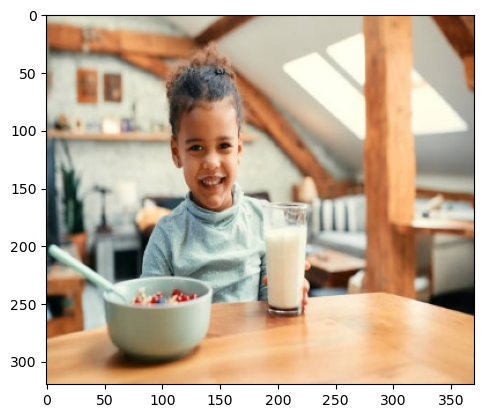

In [289]:
file = 'data/control/3.jpg'
plt.imshow(cv2.cvtColor(cv2.imread(file), cv2.COLOR_BGR2RGB))
check_detection(file)

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

from sklearn.tree import DecisionTreeClassifier, plot_tree


In [ ]:
classification_features = data_processed[['Smile_w_prop', 'Smile_h_prop', 'Eye1_w_prop', 'Eye2_w_prop', 'forehead_prop', 'nose_prop', 'chin_prop']]

classification_target = data_processed['Classification']

In [ ]:
knn = KNeighborsClassifier(5)

knn.fit(classification_features, classification_target)

data_processed['Prediction'] = knn.predict(classification_features)

In [ ]:
accuracy = np.mean(data_processed['Prediction'] == data_processed['Classification'])

def precision(actual, predicted, positive='DownSyndrome'):
    TP = np.sum((actual == positive) & (predicted == positive))
    TN = np.sum((actual != positive) & (predicted != positive))
    FP = np.sum((actual != positive) & (predicted == positive))
    FN = np.sum((actual == positive) & (predicted != positive))
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    output = f"Precision: {precision*100:.1f}% (TP: {TP}, TN: {TN}, FP: {FP}, FN: {FN})"
    return(output)

print(precision(data_processed['Classification'], data_processed['Prediction'], positive='DownSyndrome'))
print(precision(data_processed['Classification'], data_processed['Prediction'], positive='Control'))
print(f"Overall accuracy: {accuracy*100:.1f}%")

Precision: 94.4% (TP: 850, TN: 41, FP: 50, FN: 16)
Precision: 71.9% (TP: 41, TN: 850, FP: 16, FN: 50)
Overall accuracy: 93.1%


In [ ]:
tree = DecisionTreeClassifier(max_depth=5)

tree.fit(classification_features, classification_target)

data_processed['Prediction'] = tree.predict(classification_features)

In [ ]:
accuracy = np.mean(data_processed['Prediction'] == data_processed['Classification'])

print(precision(data_processed['Classification'], data_processed['Prediction'], positive='DownSyndrome'))
print(precision(data_processed['Classification'], data_processed['Prediction'], positive='Control'))
print(f"Overall accuracy: {accuracy*100:.1f}%")


Precision: 95.4% (TP: 852, TN: 50, FP: 41, FN: 14)
Precision: 78.1% (TP: 50, TN: 852, FP: 14, FN: 41)
Overall accuracy: 94.3%


In [ ]:
accuracy = np.mean(data_processed['Prediction'] == data_processed['Classification'])

print(precision(data_processed['Classification'], data_processed['Prediction'], positive='DownSyndrome'))
print(precision(data_processed['Classification'], data_processed['Prediction'], positive='Control'))
print(f"Overall accuracy: {accuracy*100:.1f}%")


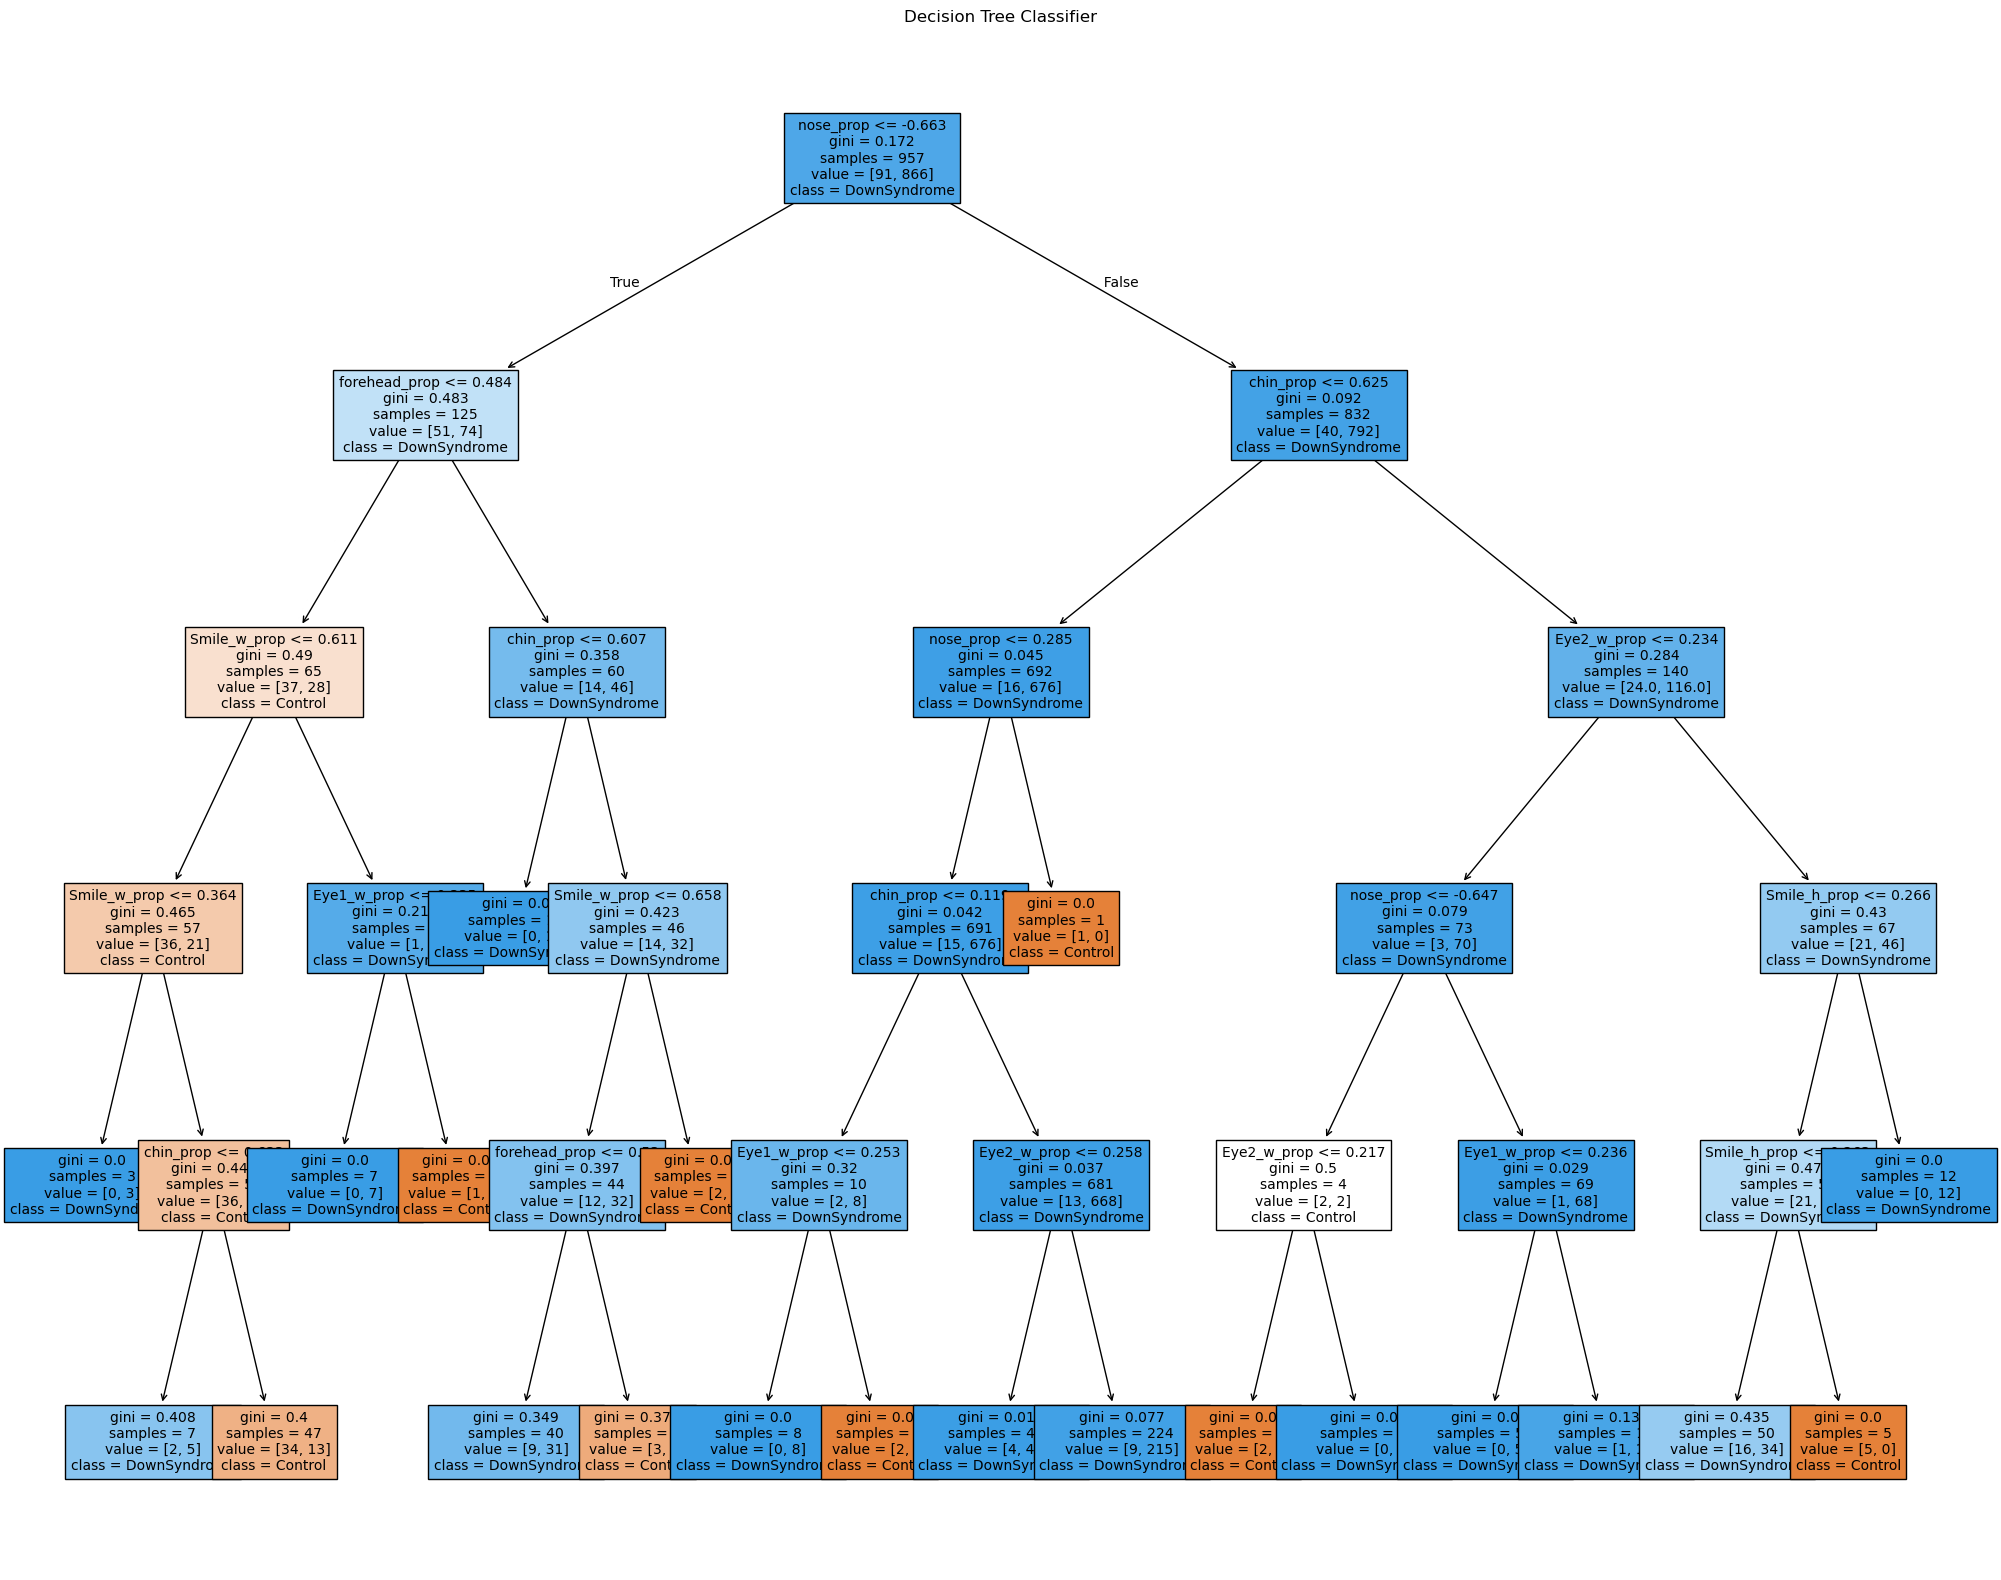

In [ ]:
# Create a tree plot for the decision tree
plt.figure(figsize=(25, 20))
plot_tree(tree,
          feature_names=classification_features.columns,
          # Use the class names from the classification target to colour the diagram
          class_names = classification_target.unique(),
          filled=True, fontsize=10)
plt.title(f'Decision Tree Classifier')
plt.show()

In [268]:
from joblib import dump, load
dump(tree, 'tree.joblib')
tree_load = load('tree.joblib')

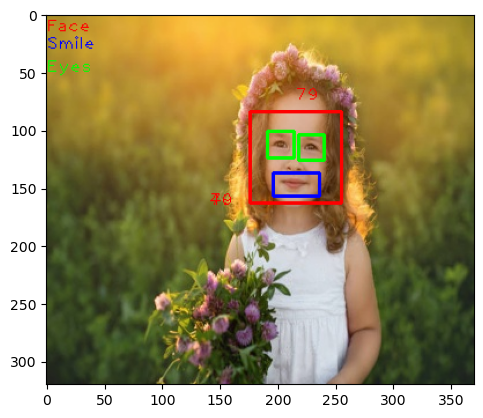

In [ ]:
file = 'data/control/87.jpg'
check_detection(file)